# ENDG 511 Final Project Prune & Quantization Code - Final

### 📌 **Required Installations**
If you haven't installed all the required dependencies, run the following command to ensure the required libraries are installed:

```bash
pip install numpy matplotlib torch timm scipy tqdm scikit-learn seaborn h5py pillow torchvision timm
```

If you are using **google colaboratory**, skip this step.

## [1] Imports  

In this section, we install and import the necessary libraries required for the code to run.  

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
from random import sample
from PIL import Image
import timm.models.vision_transformer
from timm.layers import trunc_normal_
import math
import sys
from typing import Iterable
from timm.utils import accuracy
import datetime
import time
from collections import defaultdict, deque
import torch.distributed as dist
from torch.utils.data import DataLoader, random_split, Subset
from torch import nn
from functools import partial
import torch.nn.functional as F
from scipy.io import loadmat
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.utils.data import Dataset
import re
import h5py
from torchvision import models
from torchvision.transforms import (
    Grayscale, ToTensor, Compose, Resize, InterpolationMode, Normalize, Lambda, RandomPerspective, RandomCrop
)
plt.rcParams['font.family'] = 'serif'

In [2]:
## Setup functions for later

def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if v is None:
                continue
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        log_msg = [
            header,
            '[{0' + space_fmt + '}/{1}]',
            'eta: {eta}',
            '{meters}',
            'time: {time}',
            'data: {data}'
        ]
        if torch.cuda.is_available():
            log_msg.append('max mem: {memory:.0f}')
        log_msg = self.delimiter.join(log_msg)
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))


### Learning and Optimization Utilities  

These utilities handle learning rate scheduling, gradient scaling, and other optimization techniques. They are quite complex, so feel free to skip them.  


In [3]:
def adjust_learning_rate(optimizer, epoch, warmup_epochs, lr, min_lr=1e-6):
    """Decay the learning rate with half-cycle cosine after warmup"""
    if epoch < warmup_epochs:
        lr = lr * epoch / warmup_epochs
    else:
        lr = min_lr + (lr - min_lr) * 0.5 * \
            (1. + math.cos(math.pi * (epoch - warmup_epochs) / (epochs - warmup_epochs)))
    for param_group in optimizer.param_groups:
        if "lr_scale" in param_group:
            param_group["lr"] = lr * param_group["lr_scale"]
        else:
            param_group["lr"] = lr
    return lr

def get_layer_id_for_vit(name, num_layers):
    """
    Assign a parameter with its layer id
    Following BEiT: https://github.com/microsoft/unilm/blob/master/beit/optim_factory.py#L33
    """
    if name in ['cls_token', 'pos_embed']:
        return 0
    elif name.startswith('patch_embed'):
        return 0
    elif name.startswith('blocks'):
        return int(name.split('.')[1]) + 1
    else:
        return num_layers

def param_groups_lrd(model, weight_decay=0.05, no_weight_decay_list=[], layer_decay=.75):
    """
    Parameter groups for layer-wise lr decay
    Following BEiT: https://github.com/microsoft/unilm/blob/master/beit/optim_factory.py#L58
    """
    param_group_names = {}
    param_groups = {}

    num_layers = 53#len(model.blocks) + 1

    layer_scales = list(layer_decay ** (num_layers - i) for i in range(num_layers + 1))

    for n, p in model.named_parameters():
        if not p.requires_grad:
            continue

        # no decay: all 1D parameters and model specific ones
        if p.ndim == 1 or n in no_weight_decay_list:
            g_decay = "no_decay"
            this_decay = 0.
        else:
            g_decay = "decay"
            this_decay = weight_decay

        layer_id = get_layer_id_for_vit(n, num_layers)
        group_name = "layer_%d_%s" % (layer_id, g_decay)

        if group_name not in param_group_names:
            this_scale = layer_scales[layer_id]

            param_group_names[group_name] = {
                "lr_scale": this_scale,
                "weight_decay": this_decay,
                "params": [],
            }
            param_groups[group_name] = {
                "lr_scale": this_scale,
                "weight_decay": this_decay,
                "params": [],
            }

        param_group_names[group_name]["params"].append(n)
        param_groups[group_name]["params"].append(p)

    # print("parameter groups: \n%s" % json.dumps(param_group_names, indent=2))

    return list(param_groups.values())

def get_grad_norm_(parameters, norm_type: float = 2.0) -> torch.Tensor:
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    parameters = [p for p in parameters if p.grad is not None]
    norm_type = float(norm_type)
    if len(parameters) == 0:
        return torch.tensor(0.)
    device = parameters[0].grad.device
    if norm_type == torch.inf:
        total_norm = max(p.grad.detach().abs().max().to(device) for p in parameters)
    else:
        total_norm = torch.norm(torch.stack([torch.norm(p.grad.detach(), norm_type).to(device) for p in parameters]), norm_type)
    return total_norm

class NativeScalerWithGradNormCount:
    state_dict_key = "amp_scaler"

    def __init__(self):
        self._scaler = torch.cuda.amp.GradScaler()

    def __call__(self, loss, optimizer, clip_grad=None, parameters=None, create_graph=False, update_grad=True):
        self._scaler.scale(loss).backward(create_graph=create_graph)
        if update_grad:
            if clip_grad is not None:
                assert parameters is not None
                self._scaler.unscale_(optimizer)  # unscale the gradients of optimizer's assigned params in-place
                norm = torch.nn.utils.clip_grad_norm_(parameters, clip_grad)
            else:
                self._scaler.unscale_(optimizer)
                norm = get_grad_norm_(parameters)
            self._scaler.step(optimizer)
            self._scaler.update()
        else:
            norm = None
        return norm

    def state_dict(self):
        return self._scaler.state_dict()

    def load_state_dict(self, state_dict):
        self._scaler.load_state_dict(state_dict)


class LabelSmoothingCrossEntropy(nn.Module):
    """ NLL loss with label smoothing.
    """
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        assert smoothing < 1.0
        self.smoothing = smoothing
        self.confidence = 1. - smoothing

    def forward(self, x: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

### Model Training Utilities  

This section contains utility functions that will be useful across all tasks.  

In [5]:
def train_one_epoch(model: torch.nn.Module, criterion: torch.nn.Module,
                    data_loader: Iterable, optimizer: torch.optim.Optimizer,
                    device: torch.device, epoch: int, warmup_epochs: int, lr, loss_scaler,
                    task: str = "classification"):
    """
    Trains the model for one epoch, supporting both classification and regression tasks.

    Parameters:
    ----------
    model : torch.nn.Module
        The model to train.
    criterion : torch.nn.Module
        The loss function.
    data_loader : Iterable
        The dataset loader.
    optimizer : torch.optim.Optimizer
        The optimizer used for training.
    device : torch.device
        Device to run training on (CPU or GPU).
    epoch : int
        Current epoch number.
    loss_scaler : callable
        Function to scale loss for mixed precision training.
    max_norm : float, optional
        Gradient clipping norm, by default 0.
    log_writer : object, optional
        Logger for TensorBoard, by default None.
    args : object, optional
        Additional training arguments.
    task : str, optional
        Task type: `"classification"` or `"regression"`, by default `"classification"`.

    Returns:
    -------
    dict
        Averaged metrics (loss, accuracy if classification).
    """
    model.train(True)
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = f'Epoch: [{epoch}]'
    print_freq = 20

    optimizer.zero_grad()


    for data_iter_step, (samples, targets, filename) in enumerate(metric_logger.log_every(data_loader, print_freq, header)):

        # Adjust learning rate per iteration
        adjust_learning_rate(optimizer, data_iter_step / len(data_loader) + epoch, warmup_epochs, lr)

        samples, targets = samples.to(device, non_blocking=True), targets.to(device, non_blocking=True)

        # Forward pass
        with torch.cuda.amp.autocast():
            outputs = model(samples)
            loss = criterion(outputs, targets)

        loss_value = loss.item()
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            sys.exit(1)

        # Backpropagation
        loss_scaler(loss, optimizer, parameters=model.parameters(), create_graph=False,
                    update_grad=True)
        optimizer.zero_grad()

        #torch.cuda.synchronize()

        # Update metrics
        metric_logger.update(loss=loss_value)

        if task == "classification":
            acc1, acc3 = accuracy(outputs, targets, topk=(1, 3))
            metric_logger.meters['acc1'].update(acc1.item(), n=samples.shape[0])
            metric_logger.meters['acc3'].update(acc3.item(), n=samples.shape[0])

        # Track learning rate
        max_lr = max(group["lr"] for group in optimizer.param_groups)
        metric_logger.update(lr=max_lr)

    # Synchronize metrics across processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)

    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}


@torch.no_grad()
def evaluate(data_loader, model, criterion, device, task: str = "classification"):
    """
    Evaluates the model on the provided dataset.

    Parameters:
    ----------
    data_loader : Iterable
        Dataset loader.
    model : torch.nn.Module
        The model to evaluate.
    criterion : torch.nn.Module
        Loss function.
    device : torch.device
        Device for evaluation.
    task : str, optional
        Task type: `"classification"` or `"regression"`, by default `"classification"`.

    Returns:
    -------
    dict
        Averaged evaluation metrics.
    """
    metric_logger = MetricLogger(delimiter="  ")
    header = 'Test:'

    model.eval()

    for batch in metric_logger.log_every(data_loader, 10, header):
        images, targets, filename = batch[0].to(device, non_blocking=True), batch[1].to(device, non_blocking=True), batch[2]

        # Compute output
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, targets)

        metric_logger.update(loss=loss.item())

        if task == "classification":
            acc1, acc3 = accuracy(outputs, targets, topk=(1, 3))
            metric_logger.meters['acc1'].update(acc1.item(), n=images.shape[0])
            metric_logger.meters['acc3'].update(acc3.item(), n=images.shape[0])

    # Synchronize metrics across processes
    metric_logger.synchronize_between_processes()

    if task == "classification":
        print('* Acc@1 {top1.global_avg:.3f} Acc@3 {top3.global_avg:.3f} loss {losses.global_avg:.3f}'
              .format(top1=metric_logger.acc1, top3=metric_logger.acc3, losses=metric_logger.loss))
    else:
        print('* Loss {losses.global_avg:.3f}'.format(losses=metric_logger.loss))

    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}


In [6]:
def freeze_model(model, num_blocks: int):
    """
    Freezes the transformer encoder to prevent updates during training.
    Parameters:
    ----------
    num_blocks : int
        The number of layers to freeze.
    """
    for i, (name, module) in enumerate(model.named_children()):
        if i < num_blocks:
            for param in module.parameters():
                param.requires_grad = False
        else:
            for param in module.parameters():
                param.requires_grad = True

## [3] Vision Transformer Class  

This section defines a **custom Vision Transformer (ViT) model** that extends the `timm` implementation. This is the architecture we use for the **Radio Foundation Model**.

### Key Features:
- **Global Pooling Support:**  
  - Supports different pooling strategies (`'token'`, `'avg'`, `'max'`, etc.).
- **Tanh Activation:**  
  - Can apply a **tanh activation function** in the output.
- **Encoder Freezing:**  
  - Allows freezing either the **entire transformer encoder** or **a specified number of blocks**.
- **Pretrained Model Loading:**  
  - Implements methods to **load weights from a checkpoint**.  

This model is designed to be flexible and easily integrated into various tasks.


In [7]:
class VisionTransformer(timm.models.vision_transformer.VisionTransformer):
    """
    A custom Vision Transformer (ViT) model extending the timm VisionTransformer implementation.

    This class supports:
    - **Global Pooling Strategies**: Allows different pooling methods ('token', 'avg', 'max', etc.).
    - **Tanh Activation**: Applies tanh activation to the output if enabled.
    - **Encoder Freezing**: Allows freezing part or all of the transformer encoder.
    - **Checkpoint Handling**: Supports loading model weights from a checkpoint.

    Attributes:
    ----------
    task : str, required
        Specifies the task ('signal_identification', 'sensing', 'positioning')
    global_pool : str
        The pooling method to apply. Options: 'token', 'avg', 'max', etc.
    tanh : bool
        Applies tanh activation to the final output if set to True.
    """

    def __init__(self, task: str, global_pool: str = "token", tanh: bool = False, **kwargs):
        """
        Initializes the Vision Transformer model.

        Parameters:
        ----------
        global_pool : str, optional
            Specifies the pooling method ('token', 'avg', 'max', etc.), by default "token".
        tanh : bool, optional
            Whether to apply tanh activation to the output, by default False.
        kwargs : dict
            Additional arguments for the base VisionTransformer class.
        """
        super(VisionTransformer, self).__init__(**kwargs)
        self.task = task
        self.global_pool = global_pool
        self.tanh = tanh

    def freeze_encoder(self, num_blocks: int = None):
        """
        Freezes the transformer encoder to prevent updates during training.

        Parameters:
        ----------
        num_blocks : int, optional
            The number of transformer blocks to freeze. If None, freezes the entire encoder.
        """
        if num_blocks is None:
            for param in self.blocks.parameters():
                param.requires_grad = False
        else:
            for param in self.blocks[:num_blocks].parameters():
                param.requires_grad = False

        # Also freeze the patch embedding layer
        for param in self.patch_embed.proj.parameters():
            param.requires_grad = False

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the Vision Transformer.

        Parameters:
        ----------
        x : torch.Tensor
            Input tensor of shape (batch_size, channels, height, width).

        Returns:
        -------
        torch.Tensor
            Output tensor after the forward pass.
        """
        x = self.forward_features(x)  # Extracts features using the transformer backbone
        x = self.forward_head(x)  # Passes features through the classifier head

        if self.tanh:
            return torch.tanh(x)  # Applies tanh activation if enabled
        return x

    def save_model(self, path: str):
        """
        Saves the model's state dictionary to a checkpoint file.

        Parameters:
        ----------
        path : str
            Path where the model checkpoint will be saved.
        """
        checkpoint = {
            "model": self.state_dict(),  # Save model weights
        }

        torch.save(checkpoint, path)
        print(f"Model successfully saved to {path}")

    def load_model(self, checkpoint_path: str) -> dict:
        """
        Loads model weights from a given checkpoint file.

        Parameters:
        ----------
        checkpoint_path : str
            Path to the checkpoint file.

        Returns:
        -------
        dict
            A message indicating the status of the checkpoint loading.
        """
        checkpoint = torch.load(checkpoint_path, map_location='cpu')  # Load checkpoint
        checkpoint_model = checkpoint['model']  # Extract model weights
        msg = self.load_state_dict(checkpoint_model, strict=True)  # Load state dictionary
        return msg  # Return loading message

    def load_from_pretrained(self, path: str):
        """
        Loads a model from a pretrained checkpoint while handling task-specific modifications.

        Parameters:
        ----------
        path : str
            Path to the pretrained model checkpoint.

        Returns:
        -------
        msg : dict
            A message from `load_state_dict()` indicating missing/unexpected keys.
        """
        # Load checkpoint
        checkpoint = torch.load(path, map_location='cpu')
        checkpoint_model = checkpoint.get('model', {})

        # Get current model's state dictionary
        state_dict = self.state_dict()

        # Define keys to be removed if mismatched
        keys_to_remove = ['head.weight', 'head.bias']

        if self.task in ['sensing', 'positioning']:
            keys_to_remove.append('pos_embed')

        # Remove incompatible keys
        for key in keys_to_remove:
            if key in checkpoint_model and checkpoint_model[key].shape != state_dict[key].shape:
                print(f"Removing key {key} from pretrained checkpoint")
                del checkpoint_model[key]

        # Adjust patch embedding projection layer for specific tasks
        patch_embed_key = 'patch_embed.proj.weight'
        if self.task == 'sensing':
            checkpoint_model[patch_embed_key] = checkpoint_model[patch_embed_key].expand(-1, 3, -1, -1)
        elif self.task == 'positioning':
            checkpoint_model[patch_embed_key] = checkpoint_model[patch_embed_key].expand(-1, 4, -1, -1)

        # Load state dictionary with `strict=False` to allow missing/unexpected keys
        msg = self.load_state_dict(checkpoint_model, strict=False)
        # Manually initialize fc layer
        #trunc_normal_(self.head.weight, std=2e-5)

        # If self.head is Sequential, access the first layer's weights
        if isinstance(self.head, torch.nn.Sequential):
            trunc_normal_(self.head[0].weight, std=2e-5)  
        else:
            trunc_normal_(self.head.weight, std=2e-5)  
        return msg

# ⚙️ Main Task Data Model




## Data Visualization

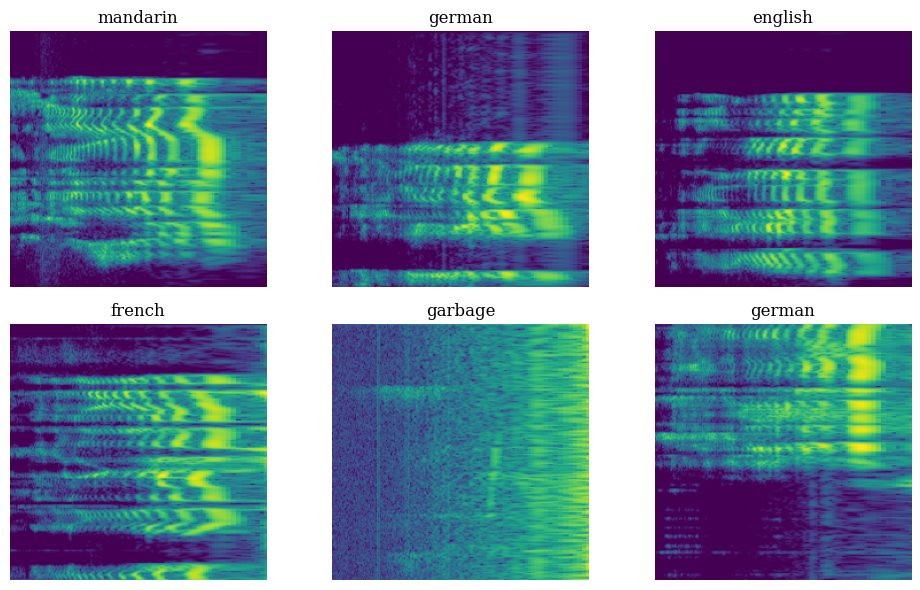

In [8]:
# Define the dataset path (Update if the path is different)
data_dir2 = Path("languages")
#data_dir2 = Path("/content/drive/MyDrive/ENDG_511_Lab2_Seleem_Badawy_Benjamin_Pele/data/radio_signal_identification/radio_signal_identification")

# List all spectrogram files in the directory
spectrogram_filenames = os.listdir(data_dir2)
# Number of spectrogram samples to visualize
num_samples = 6
# Randomly select 'num_samples' spectrogram files from the dataset
selected_files = sample(spectrogram_filenames, num_samples)

# Create a 2x3 grid for visualization
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)
# Iterate through selected files and plot spectrograms
for i, ax in enumerate(axes.ravel()):
    # Load spectrogram image
    spectrogram_path = os.path.join(data_dir2, selected_files[i])
    spectrogram = np.array(Image.open(spectrogram_path).convert("L").resize((224, 224))).T
    # Ensure the spectrogram has correct dimensions
    spectrogram = np.squeeze(spectrogram)
    # Display the spectrogram
    ax.imshow(spectrogram, cmap="viridis")  # Ensuring a grayscale colormap
    ax.set_title(selected_files[i].split('_')[0])  # Extract class label from filename
    ax.axis("off")  # Hide axes for better visualization

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [9]:
import random
class LanguageDataset(Dataset):
    """
    A PyTorch Dataset class for loading and processing spectrogram images of radio signals.

    This dataset:
    - Loads images from a specified directory.
    - Applies preprocessing transformations (grayscale conversion, resizing, normalization).
    - Computes class weights for handling class imbalance.
    - Returns image tensors along with their respective labels.

    Attributes:
    ----------
    data_dir : str
        Path to the dataset directory.
    class_labels : list
        List of signal class names.
    class_weights : torch.Tensor
        Normalized inverse frequency weights for each class.
    data_files : list
        List of all image file names in the dataset.
    transform : torchvision.transforms.Compose
        Transformations applied to each image.
    """

    def __init__(self, data_dir, augment=False):
        """
        Initializes the dataset by loading class names, computing class frequencies, and setting up transformations.

        Parameters:
        ----------
        data_dir : str
            Path to the dataset directory.
        """
        self.data_dir = data_dir

        # Define class labels (must match the dataset naming convention)
        self.class_labels = [ 'arabic', 'english', 'german', 'mandarin', 'spanish', 'garbage', 'french']
        #self.class_labels = [ 'arabic', 'german', 'mandarin', 'french']
        self.random_crop = RandomCrop(size=(224, 224))  # assuming final size
        self.augment = augment

        # Get all filenames from the dataset directory
        self.data_files = os.listdir(data_dir)

        # Compute class frequencies (how many samples per class exist)
        class_counts = {label: sum(1 for file in self.data_files if file.startswith(label)) for label in self.class_labels}

        # Compute class weights (inverse frequency) to handle class imbalance
        total_samples = sum(class_counts.values())
        class_weights = [1 / (count / total_samples) if count > 0 else 0 for count in class_counts.values()]

        # Normalize class weights so they sum to 1
        class_weights_sum = sum(class_weights)
        self.class_weights = torch.tensor([w / class_weights_sum for w in class_weights], dtype=torch.float)

        # Define image transformations
        self.transform = Compose([
            ToTensor(),
            Grayscale(num_output_channels=3),
            Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
            RandomPerspective(distortion_scale=0.5, p=0.5),  # Perspective distortion
            Normalize(mean=[-0.9256, -0.8168, -0.5910], std=[0.1704, 0.1742, 0.1734])
        ])

    def __getitem__(self, index):
        """
        Loads an image, applies transformations, and returns it along with its label index.

        Parameters:
        ----------
        index : int
            Index of the sample in the dataset.

        Returns:
        -------
        tuple(torch.Tensor, torch.Tensor)
            Transformed image tensor and its corresponding label index.
        """
        # Get the filename of the sample
        file_name = self.data_files[index]
        file_path = os.path.join(self.data_dir, file_name)

        # Load the image
        image = Image.open(file_path)

        # Rotate 90 degrees (optional, remove if unnecessary)
        image = image.transpose(Image.ROTATE_90)

        # Ensure the image is in RGB mode (some formats might be grayscale)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        image = self.random_crop(image)
        #image = self.transform(image)

       # Convert image to spectrogram (numpy array) and apply augmentation
        spectrogram = np.array(image)

        if self.augment:
            spectrogram = self.apply_spec_augment(spectrogram)

        # Convert to tensor and apply transformations
        image_tensor = self.transform(Image.fromarray(spectrogram))

        if self.augment:
            image_tensor = self.apply_noise(image_tensor)
        # Extract the class label from the filename
        class_label = file_name.split('_')[0]
        sample_number = file_name.split('_')[1]
        label_index = self.class_labels.index(class_label)

        # Apply transformations and return image with label
        return image_tensor, torch.tensor(label_index, dtype=torch.long), sample_number

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
        -------
        int
            Number of files in the dataset.
        """
        return len(self.data_files)
    def apply_spec_augment(self, spectrogram):
        """Apply SpecAugment (time and frequency masking)"""
        # Apply time and frequency masking using librosa
        spectrogram = self.time_mask(spectrogram)
        spectrogram = self.freq_mask(spectrogram)
        return spectrogram

    def time_mask(self, spectrogram, max_mask_size=50):
        """Apply time masking to the spectrogram"""
        n_frames = spectrogram.shape[1]
        mask_start = random.randint(0, n_frames - max_mask_size)
        mask_end = mask_start + random.randint(1, max_mask_size)
        spectrogram[:, mask_start:mask_end] = 0
        return spectrogram

    def freq_mask(self, spectrogram, max_mask_size=10):
        """Apply frequency masking to the spectrogram"""
        n_freqs = spectrogram.shape[0]
        mask_start = random.randint(0, n_freqs - max_mask_size)
        mask_end = mask_start + random.randint(1, max_mask_size)
        spectrogram[mask_start:mask_end, :] = 0
        return spectrogram
    
    def apply_noise(self, img_tensor, noise_level=0.03):
        noise = torch.randn_like(img_tensor) * noise_level
        return torch.clamp(img_tensor + noise, 0.0, 1.0)  # Keep within valid image range


In [47]:
import torch
#import torch_directml
torch.cuda.empty_cache()

In [10]:
# Fixed parameters
task = 'languages'
task_type = "classification"

# Configurable parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch_directml.device()
train_test_split = 0.8
batch_size = 16
num_workers = 0
frozen_blocks = 0
label_smoothing = 0.1
lr = 1e-3#1e-2
weight_decay = 0.05
layer_decay = 0.75
model_size = 'small'
epochs = 20#50#10
warmup_epochs = 4#2#1
output_dir = 'models'

In [14]:
import sklearn
def stratified_split(dataset, train_test_split):
    """
    Implement a Stratified Split for an imbalanced dataset.

    Parameters:
    -----------
    dataset : Dataset
        The dataset to split.
    train_test_split : float
        The proportion of data to allocate for training.

    Returns:
    --------
    tuple : (train_dataset, test_dataset)
        The stratified training and validation datasets.
    """
    splitter = sklearn.model_selection.StratifiedShuffleSplit(train_size=train_test_split, random_state=None)

    labels_iterable = [dataset[i][1] for i in range(len(dataset))]

    for train_index, test_index in splitter.split(range(len(dataset)), labels_iterable):

            train_dataset = [dataset[i] for i in train_index]
            test_dataset = [dataset[i] for i in test_index]

    return train_dataset, test_dataset
    #raise NotImplementedError


In [16]:
# Load dataset
dataset = LanguageDataset(Path('languages'))  # Update path if needed

# Set random seed for reproducibility
seed = 42

#dataset_train = [ ]
#dataset_val = [ ]

#loop used to try ensuring samples from same audio file were matched as either training or validation data
#for item in dataset:
#    image, label, sample_number = item
#    sample_number = int(sample_number.replace(".png", "")) // 1000
#    print("number is: ",sample_number)
#    if sample_number < 1000: #condition for homemade data
#        dataset_train.append(item)
#    else:
#        if (sample_number % 10 in [0, 1, 2, 3, 4, 5, 6, 7]): #make as close as possible to 80-20 split
#            dataset_train.append(item)
#        else:
#            dataset_val.append(item)
#print("val length: ", len(dataset_val))
#print("train length: ", len(dataset_train))
#print(f"train test split is {len(dataset_train)/(len(dataset_train) + len(dataset_val))}")
#
# ⁉️Replace the line below with your stratified split implementation
dataset_train, dataset_val = stratified_split(dataset, train_test_split=0.8)#[train_test_split, 1 - train_test_split],
                                          #generator=torch.Generator().manual_seed(seed))
#dataset_val, dataset_test = stratified_split(dataset_val, train_test_split=0.5) #split val set in half to hide some data

# Create dataloaders
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers,
                               pin_memory=True, drop_last=True)
data_loader_val = DataLoader(dataset_val, batch_size=batch_size, num_workers=num_workers,
                             pin_memory=True, drop_last=False)
#data_loader_test = DataLoader(dataset_test, batch_size=batch_size, num_workers=num_workers,
#                             pin_memory=True, drop_last=False)

# Initialize Vision Transformer model based on size
if model_size == 'small':
    model = VisionTransformer(task=task, patch_size=16, embed_dim=512, depth=12, num_heads=8,
                              mlp_ratio=4, qkv_bias=True, in_chans=1,
                              norm_layer=partial(nn.LayerNorm, eps=1e-6),
                              num_classes=5)
elif model_size == 'medium':
    model = VisionTransformer(task=task, patch_size=16, embed_dim=768, depth=12, num_heads=12,
                              mlp_ratio=4, qkv_bias=True, in_chans=1,
                              norm_layer=partial(nn.LayerNorm, eps=1e-6),
                              num_classes=20)
elif model_size == 'large':
    model = VisionTransformer(task=task, patch_size=16, embed_dim=1024, depth=24, num_heads=16,
                              mlp_ratio=4, qkv_bias=True, in_chans=1,
                              norm_layer=partial(nn.LayerNorm, eps=1e-6),
                              num_classes=20)
else:
    raise ValueError('Model size must be either small, medium, or large')

# Load pretrained weights and freeze encoder blocks
#checkpoint_path = Path('pretrained_small_75.pth')  # Update if needed
#model.load_from_pretrained(checkpoint_path)
#model.freeze_encoder(frozen_blocks)

#force mobilenets_v2
model = models.mobilenet_v2(pretrained=True)
freeze_model(model, frozen_blocks)
model.classifier[1] = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.2), #overfitting help
    nn.Linear(128, 7)  # Change output to 7 classes
)

#commented out, was used for Resnet18 tests
#model.fc = nn.Sequential(
#    nn.Dropout(0.3),
#    nn.Linear(model.fc.in_features, 256),
#    nn.BatchNorm1d(256),
#    nn.ReLU(inplace=True),
#    
#    nn.Dropout(0.3),
#    nn.Linear(256, 128),
#    nn.BatchNorm1d(128),
#    nn.ReLU(inplace=True),
#    
#    nn.Linear(128, 7)
#)
model.to(device)

# Initialize optimizer
param_groups = param_groups_lrd(model, weight_decay=weight_decay)
optimizer = torch.optim.AdamW(param_groups, lr=lr)
loss_scaler = NativeScalerWithGradNormCount()

#from torch.optim.lr_scheduler import CosineAnnealingLR
#scheduler = CosineAnnealingLR(optimizer, T_max=10)
# Display model info
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model: {model}")
print(f"Number of parameters: {n_parameters / 1.e6:.2f}M")
print(f"Base learning rate: {lr * 256 / batch_size:.2e}")
print(f"Actual learning rate: {lr:.2e}")

# Define loss function
#criterion = nn.CrossEntropyLoss()
#print(f"Criterion: {criterion}")

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

#criterion = FocalLoss(alpha=dataset.class_weights.to(device), gamma=2.0)

criterion = nn.CrossEntropyLoss(weight=dataset.class_weights.to(device))#label_smoothing=label_smoothing) ## Fixes run time error
print(f"Criterion: {criterion}")

Model: MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(9

/Users/SeleemB/miniconda3/envs/endg511_project/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/SeleemB/miniconda3/envs/endg511_project/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/SeleemB/miniconda3/envs/endg511_project/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.43E-04


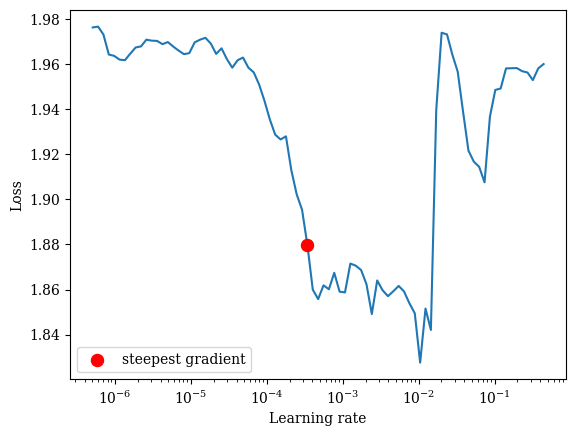

In [18]:
from torch_lr_finder import LRFinder

model = model.to(device)
criterion = nn.CrossEntropyLoss(weight=dataset.class_weights.to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-7)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(data_loader_train, end_lr=1, num_iter=100)
lr_finder.plot()  # Look at the plot to determine optimal LR
lr_finder.reset()

In [ ]:
# didn't re-run this
'''
print(f"Starting training for {epochs} epochs...")

start_time = time.time()
max_accuracy = 0.0
for epoch in range(epochs):
    # Train for one epoch
    train_stats = train_one_epoch(model, criterion, data_loader_train, optimizer, device, epoch,
                                  warmup_epochs, lr, loss_scaler, task_type)

    # Save model checkpoint every 10 epochs
    #if output_dir and epoch % 10 == 0:
    #    model.save_model(os.path.join(output_dir, f'checkpoint-{epoch}.pth'))

    # Evaluate the model
    test_stats = evaluate(data_loader_val, model, criterion, device, task_type)

    # Log accuracy
    print(f"Accuracy on {len(dataset_val)} test samples: {test_stats['acc1']:.3f}%")
    max_accuracy = max(max_accuracy, test_stats["acc1"])
    print(f"Max accuracy so far: {max_accuracy:.3f}%")

#save model for submission
torch.save(model, os.path.join(output_dir, f'model_language_mobilenet_20_epoch_new_normalize_good_dropout.pth'))
# Compute total training time
total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f"Total training time: {total_time_str}")'''

Starting training for 20 epochs...


/Users/SeleemB/miniconda3/envs/endg511_project/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch: [0]  [  0/410]  eta: 0:09:10  lr: 0.000000  loss: 2.0075 (2.0075)  acc1: 12.5000 (12.5000)  acc3: 43.7500 (43.7500)  time: 1.3422  data: 0.0068
Epoch: [0]  [ 20/410]  eta: 0:03:11  lr: 0.000012  loss: 1.9464 (1.9518)  acc1: 12.5000 (11.3095)  acc3: 43.7500 (46.4286)  time: 0.4486  data: 0.0034
Epoch: [0]  [ 40/410]  eta: 0:02:53  lr: 0.000024  loss: 1.9146 (1.9390)  acc1: 18.7500 (16.1585)  acc3: 50.0000 (46.0366)  time: 0.4429  data: 0.0036
Epoch: [0]  [ 60/410]  eta: 0:02:38  lr: 0.000037  loss: 1.8988 (1.9210)  acc1: 18.7500 (18.3402)  acc3: 50.0000 (47.8484)  time: 0.4260  data: 0.0034
Epoch: [0]  [ 80/410]  eta: 0:02:26  lr: 0.000049  loss: 1.7555 (1.8828)  acc1: 31.2500 (21.5278)  acc3: 62.5000 (51.7747)  time: 0.4083  data: 0.0033
Epoch: [0]  [100/410]  eta: 0:02:14  lr: 0.000061  loss: 1.6265 (1.8437)  acc1: 37.5000 (24.3193)  acc3: 68.7500 (55.5693)  time: 0.3994  data: 0.0033
Epoch: [0]  [120/410]  eta: 0:02:04  lr: 0.000073  loss: 1.5520 (1.8030)  acc1: 37.5000 (26.34

In [19]:
# Prune and fine-tune model iteratively
import torch.nn.utils.prune as prune
import torch.nn as nn
import torch
import os
import time
import datetime

# Load pre-trained model with proper dropout
model = torch.load(r'/Users/SeleemB/Desktop/ENDG511_Final_Project/models/model_language_mobilenet_20_epoch_new_normalize_good_dropout.pth')

def apply_structured_pruning(model, amount=0.3, dim=0):
    """
    Applies structured pruning to all Conv2d and Linear layers
    by removing entire output channels (dim=0) or neurons (dim=1).
    """
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.ln_structured(module, name="weight", amount=amount, n=2, dim=0)
            prune.remove(module, "weight")
        elif isinstance(module, nn.Linear):
            prune.ln_structured(module, name="weight", amount=amount, n=2, dim=0)
            prune.remove(module, "weight")
    return model

def calculate_sparsity(model):
    total_params = 0
    zero_params = 0
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
            total_params += module.weight.numel()
            zero_params += torch.sum(module.weight == 0).item()
    sparsity = 100.0 * zero_params / total_params
    return sparsity

# Iterative pruning configuration
iterations = 5            # Total number of pruning + training rounds
sparsity_step = 0.1       # Percentage to prune at each iteration
epochs_prune = 2

# Start with original model
model_pruned = model

# Iterative pruning and retraining loop
for i in range(iterations):
    print(f"\n=== Iteration {i + 1} of {iterations} ===")
    
    # Apply pruning
    model_pruned = apply_structured_pruning(model_pruned, amount=sparsity_step)

    # Start training pruned model
    print(f"Starting training for {epochs_prune} epochs...")

    start_time = time.time()
    max_accuracy = 0.0

    for epoch in range(epochs_prune):
        # Train for one epoch
        train_stats = train_one_epoch(model_pruned, criterion, data_loader_train, optimizer, device, epoch,
                                      warmup_epochs, lr, loss_scaler, task_type)

        # Evaluate on validation set
        test_stats = evaluate(data_loader_val, model_pruned, criterion, device, task_type)

        # Log accuracy
        print(f"Accuracy on {len(dataset_val)} test samples: {test_stats['acc1']:.3f}%")
        max_accuracy = max(max_accuracy, test_stats["acc1"])
        print(f"Max accuracy so far: {max_accuracy:.3f}%")

    # Save intermediate model
    torch.save(model_pruned, os.path.join(output_dir, f'model_pruned_iter_{i+1}.pth'))

    # Compute and log training time
    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print(f"Training time for iteration {i + 1}: {total_time_str}")

    # Compute and print sparsity
    pruned_sparsity = calculate_sparsity(model_pruned)
    print(f"Model sparsity after iteration {i + 1}: {pruned_sparsity:.2f}%")

# Save final pruned model
torch.save(model_pruned, os.path.join(output_dir, f'model_language_mobilenet_20_epoch_new_normalize_pruned_iterative_10%_2epoch_5iter.pth'))
print("\nFinal pruned and retrained model saved.")



=== Iteration 1 of 5 ===
Starting training for 2 epochs...


/Users/SeleemB/miniconda3/envs/endg511_project/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch: [0]  [  0/410]  eta: 0:02:48  lr: 0.000000  loss: 2.6404 (2.6404)  acc1: 62.5000 (62.5000)  acc3: 93.7500 (93.7500)  time: 0.4112  data: 0.0010
Epoch: [0]  [ 20/410]  eta: 0:02:39  lr: 0.000012  loss: 0.8253 (1.0812)  acc1: 68.7500 (75.0000)  acc3: 100.0000 (96.1310)  time: 0.4093  data: 0.0004
Epoch: [0]  [ 40/410]  eta: 0:02:37  lr: 0.000024  loss: 0.7288 (0.9558)  acc1: 81.2500 (77.5915)  acc3: 100.0000 (96.1890)  time: 0.4449  data: 0.0004
Epoch: [0]  [ 60/410]  eta: 0:02:29  lr: 0.000037  loss: 0.6082 (0.8887)  acc1: 75.0000 (77.9713)  acc3: 100.0000 (96.4139)  time: 0.4306  data: 0.0004
Epoch: [0]  [ 80/410]  eta: 0:02:22  lr: 0.000049  loss: 0.9297 (0.9052)  acc1: 68.7500 (76.5432)  acc3: 93.7500 (95.9877)  time: 0.4402  data: 0.0016
Epoch: [0]  [100/410]  eta: 0:02:13  lr: 0.000061  loss: 0.9755 (0.9442)  acc1: 75.0000 (76.5470)  acc3: 93.7500 (95.9777)  time: 0.4348  data: 0.0008
Epoch: [0]  [120/410]  eta: 0:02:04  lr: 0.000073  loss: 0.7503 (0.9367)  acc1: 75.0000 (76

In [20]:
def calculate_sparsity(model):
    total_params = 0
    zero_params = 0
    
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
            total_params += module.weight.numel()
            zero_params += torch.sum(module.weight == 0).item()
    
    sparsity = 100.0 * zero_params / total_params
    return sparsity

#verify sparsity of model
pruned_sparsity = calculate_sparsity(model_pruned)
print(f"pruned model sparsity: {pruned_sparsity:.2f}%")

pruned model sparsity: 10.01%


In [22]:
# quantization (dynamic)

import torch
import torch.nn as nn
import torch.quantization
import os

# Load the pruned model (ensure it's on CPU for quantization)
model_pruned = torch.load(r'models/model_language_mobilenet_20_epoch_new_normalize_pruned_iterative_10%_2epoch_5iter.pth')
model_pruned.eval()

# Apply dynamic quantization to Linear layers
quantized_model = torch.quantization.quantize_dynamic(
    model_pruned,                   # the model to quantize
    {nn.Linear},                    # layers to quantize (Conv2d not supported here)
    dtype=torch.qint8               # quantization data type to 8-bit int type
)

# Save the quantized model
quantized_model_path = "models/quantized_iterative_pruned_model_2epoch_5iter.pth"
torch.save(quantized_model, quantized_model_path)

# Report model sizes
original_size = os.path.getsize("/Users/SeleemB/Desktop/ENDG511_Final_Project/models/model_language_mobilenet_20_epoch_new_normalize_good_dropout.pth") / 1e6
quantized_size = os.path.getsize(quantized_model_path) / 1e6

print(f"Original pruned model size: {original_size:.2f} MB")
print(f"Quantized model size: {quantized_size:.2f} MB")


Original pruned model size: 9.85 MB
Quantized model size: 9.35 MB


Processing Validation Batches: 100%|██████████| 103/103 [00:08<00:00, 12.31it/s]


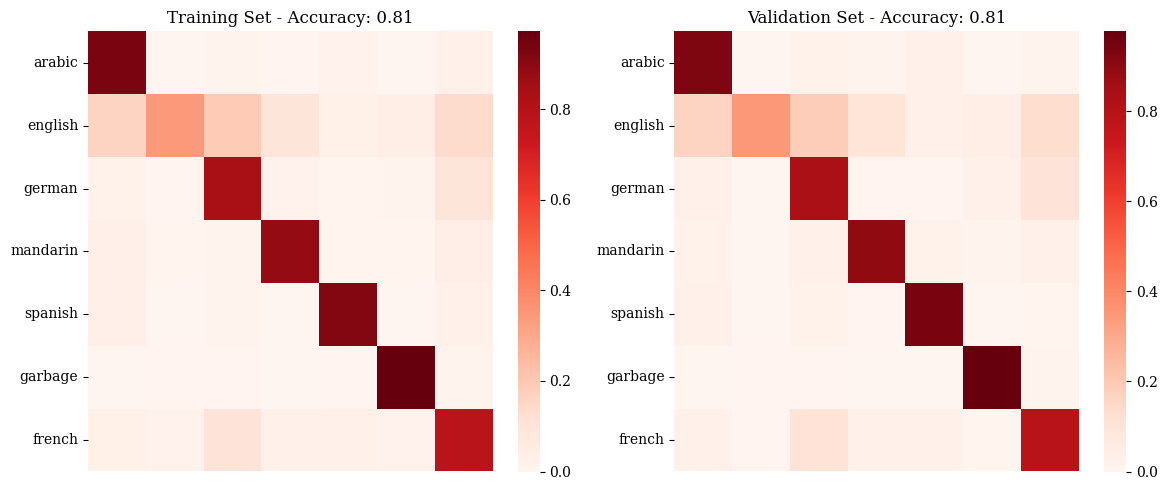

In [23]:
# Define class names for labeling confusion matrices
class_names = dataset.class_labels

# -------------------------
# 📌 Compute Predictions on Training Data
# -------------------------
all_labels_train = []
all_preds_train = []

with torch.no_grad():
    for samples, targets, filename in tqdm(data_loader_train, desc='Processing Training Batches'):
        samples, targets, filename = samples.to(device), targets.to(device), filename
        output = model_pruned(samples)  # Forward pass
        all_preds_train.extend(output.argmax(dim=-1).cpu().numpy())  # Get predicted class
        all_labels_train.extend(targets.cpu().numpy())  # Store true labels

# -------------------------
# 📌 Compute Predictions on Validation Data
# -------------------------
all_labels_val = []
all_preds_val = []

with torch.no_grad():
    for samples, targets, filename in tqdm(data_loader_val, desc='Processing Validation Batches'):
        samples, targets, filename = samples.to(device), targets.to(device), filename
        output = model_pruned(samples)  # Forward pass
        all_preds_val.extend(output.argmax(dim=-1).cpu().numpy())  # Get predicted class
        all_labels_val.extend(targets.cpu().numpy())  # Store true labels

#all_labels_test = []
#all_preds_test = []
#
#with torch.no_grad():
#    for samples, targets, filename in tqdm(data_loader_test, desc='Processing Test Batches'):
#        samples, targets, filename = samples.to(device), targets.to(device), filename
#        output = model(samples)  # Forward pass
#        all_preds_test.extend(output.argmax(dim=-1).cpu().numpy())  # Get predicted class
#        all_labels_test.extend(targets.cpu().numpy())  # Store true labels

# -------------------------
# 📌 Compute Confusion Matrices
# -------------------------
conf_mat_train = confusion_matrix(all_labels_train, all_preds_train)
conf_mat_val = confusion_matrix(all_labels_val, all_preds_val)
#conf_mat_test = confusion_matrix(all_labels_test, all_preds_test)

# Compute accuracy
accuracy_train = np.trace(conf_mat_train) / np.sum(conf_mat_train)  # Correct predictions / total
accuracy_val = np.trace(conf_mat_val) / np.sum(conf_mat_val)
#accuracy_test = np.trace(conf_mat_test) / np.sum(conf_mat_test)

# Convert to float for normalization
conf_mat_train = conf_mat_train.astype(np.float32)
conf_mat_val = conf_mat_val.astype(np.float32)
#conf_mat_test = conf_mat_test.astype(np.float32)

# Normalize confusion matrices by row (i.e., per-class normalization)
for i in range(len(class_names)):
    conf_mat_train[i] /= np.sum(conf_mat_train[i])  # Normalize training confusion matrix
    conf_mat_val[i] /= np.sum(conf_mat_val[i])  # Normalize val confusion matrix
 #   conf_mat_test[i] /= np.sum(conf_mat_test[i])  # Normalize val confusion matrix

# -------------------------
# 📌 Plot Confusion Matrices
# -------------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create side-by-side subplots

# Plot Training Confusion Matrix
sns.heatmap(conf_mat_train, cmap='Reds', yticklabels=class_names, ax=axs[0])
axs[0].set_title(f'Training Set - Accuracy: {accuracy_train:.2f}')
axs[0].tick_params(axis='y', labelsize=10)
axs[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Plot Test Confusion Matrix
sns.heatmap(conf_mat_val, cmap='Reds', yticklabels=class_names, ax=axs[1])
axs[1].set_title(f'Validation Set - Accuracy: {accuracy_val:.2f}')
axs[1].tick_params(axis='y', labelsize=10)
axs[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

#sns.heatmap(conf_mat_test, cmap='Reds', yticklabels=class_names, ax=axs[2])
#axs[2].set_title(f'Validation Set - Accuracy: {accuracy_test:.2f}')
#axs[2].tick_params(axis='y', labelsize=10)
#axs[2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Adjust layout for better readability
plt.tight_layout()
plt.savefig(Path('conf_radio_signal.png'), dpi=400)  # Save figure
plt.show()

In [24]:
import sklearn
def stratified_split(dataset, train_test_split):
    """
    Implement a Stratified Split for an imbalanced dataset.

    Parameters:
    -----------
    dataset : Dataset
        The dataset to split.
    train_test_split : float
        The proportion of data to allocate for training.

    Returns:
    --------
    tuple : (train_dataset, test_dataset)
        The stratified training and validation datasets.
    """
    splitter = sklearn.model_selection.StratifiedShuffleSplit(train_size=train_test_split, random_state=None)

    labels_iterable = [dataset[i][1] for i in range(len(dataset))]

    for train_index, test_index in splitter.split(range(len(dataset)), labels_iterable):

            train_dataset = [dataset[i] for i in train_index]
            test_dataset = [dataset[i] for i in test_index]

    return train_dataset, test_dataset
    #raise NotImplementedError

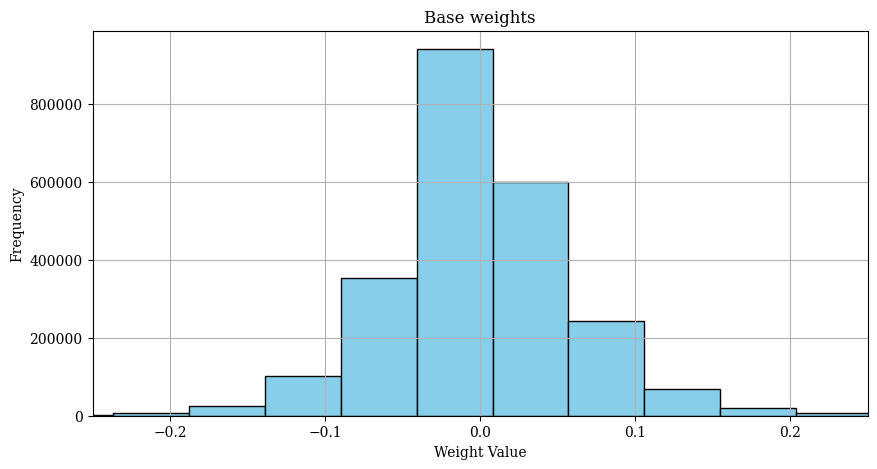

In [25]:
import matplotlib.pyplot as plt

def plot_weight_histogram(model_pruned, title="Weight Histogram"):
    all_weights = []

    for name, param in model_pruned.named_parameters():
        if 'weight' in name and param.requires_grad:
            all_weights.extend(param.detach().cpu().numpy().flatten())

    plt.figure(figsize=(10, 5))
    plt.hist(all_weights, bins=100, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.xlim((-0.25, 0.25))
    plt.show()

plot_weight_histogram(model_pruned, title="Base weights")

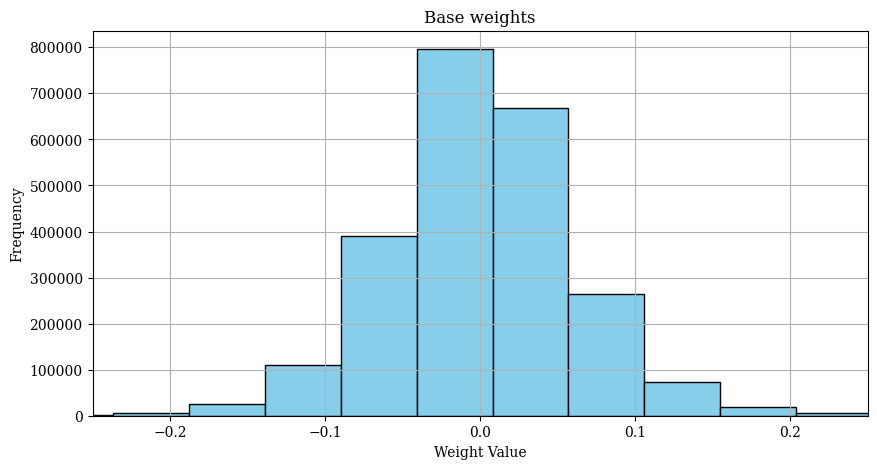

In [26]:
model_og = torch.load(r'/Users/SeleemB/Desktop/ENDG511_Final_Project/models/model_language_mobilenet_20_epoch_new_normalize_good_dropout.pth')
plot_weight_histogram(model_og, title="Base weights")

In [ ]:
print(model_pruned)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
# Define class names for labeling confusion matrices
class_names = dataset.class_labels

# -------------------------
# 📌 Compute Predictions on Training Data
# -------------------------
all_labels_train = []
all_preds_train = []

with torch.no_grad():
    for samples, targets, filename in tqdm(data_loader_train, desc='Processing Training Batches'):
        samples, targets, filename = samples.to(device), targets.to(device), filename
        output = model_pruned(samples)  # Forward pass
        all_preds_train.extend(output.argmax(dim=-1).cpu().numpy())  # Get predicted class
        all_labels_train.extend(targets.cpu().numpy())  # Store true labels

# -------------------------
# 📌 Compute Predictions on Validation Data
# -------------------------
all_labels_val = []
all_preds_val = []

with torch.no_grad():
    for samples, targets, filename in tqdm(data_loader_val, desc='Processing Validation Batches'):
        samples, targets, filename = samples.to(device), targets.to(device), filename
        output = model_pruned(samples)  # Forward pass
        all_preds_val.extend(output.argmax(dim=-1).cpu().numpy())  # Get predicted class
        all_labels_val.extend(targets.cpu().numpy())  # Store true labels

#all_labels_test = []
#all_preds_test = []
#
#with torch.no_grad():
#    for samples, targets, filename in tqdm(data_loader_test, desc='Processing Test Batches'):
#        samples, targets, filename = samples.to(device), targets.to(device), filename
#        output = model(samples)  # Forward pass
#        all_preds_test.extend(output.argmax(dim=-1).cpu().numpy())  # Get predicted class
#        all_labels_test.extend(targets.cpu().numpy())  # Store true labels

# -------------------------
# 📌 Compute Confusion Matrices
# -------------------------
conf_mat_train = confusion_matrix(all_labels_train, all_preds_train)
conf_mat_val = confusion_matrix(all_labels_val, all_preds_val)
#conf_mat_test = confusion_matrix(all_labels_test, all_preds_test)

# Compute accuracy
accuracy_train = np.trace(conf_mat_train) / np.sum(conf_mat_train)  # Correct predictions / total
accuracy_val = np.trace(conf_mat_val) / np.sum(conf_mat_val)
#accuracy_test = np.trace(conf_mat_test) / np.sum(conf_mat_test)

# Convert to float for normalization
conf_mat_train = conf_mat_train.astype(np.float32)
conf_mat_val = conf_mat_val.astype(np.float32)
#conf_mat_test = conf_mat_test.astype(np.float32)

# Normalize confusion matrices by row (i.e., per-class normalization)
for i in range(len(class_names)):
    conf_mat_train[i] /= np.sum(conf_mat_train[i])  # Normalize training confusion matrix
    conf_mat_val[i] /= np.sum(conf_mat_val[i])  # Normalize val confusion matrix
 #   conf_mat_test[i] /= np.sum(conf_mat_test[i])  # Normalize val confusion matrix

# -------------------------
# 📌 Plot Confusion Matrices
# -------------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create side-by-side subplots

# Plot Training Confusion Matrix
sns.heatmap(conf_mat_train, cmap='Reds', yticklabels=class_names, ax=axs[0])
axs[0].set_title(f'Training Set - Accuracy: {accuracy_train:.2f}')
axs[0].tick_params(axis='y', labelsize=10)
axs[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Plot Test Confusion Matrix
sns.heatmap(conf_mat_val, cmap='Reds', yticklabels=class_names, ax=axs[1])
axs[1].set_title(f'Validation Set - Accuracy: {accuracy_val:.2f}')
axs[1].tick_params(axis='y', labelsize=10)
axs[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

#sns.heatmap(conf_mat_test, cmap='Reds', yticklabels=class_names, ax=axs[2])
#axs[2].set_title(f'Validation Set - Accuracy: {accuracy_test:.2f}')
#axs[2].tick_params(axis='y', labelsize=10)
#axs[2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Adjust layout for better readability
plt.tight_layout()
plt.savefig(Path('conf_radio_signal.png'), dpi=400)  # Save figure
plt.show()

Processing Validation Batches:  93%|█████████▎| 96/103 [00:09<00:00, 10.29it/s]

In [28]:
import sklearn
def stratified_split(dataset, train_test_split):
    """
    Implement a Stratified Split for an imbalanced dataset.

    Parameters:
    -----------
    dataset : Dataset
        The dataset to split.
    train_test_split : float
        The proportion of data to allocate for training.

    Returns:
    --------
    tuple : (train_dataset, test_dataset)
        The stratified training and validation datasets.
    """
    splitter = sklearn.model_selection.StratifiedShuffleSplit(train_size=train_test_split, random_state=None)

    labels_iterable = [dataset[i][1] for i in range(len(dataset))]

    for train_index, test_index in splitter.split(range(len(dataset)), labels_iterable):

            train_dataset = [dataset[i] for i in train_index]
            test_dataset = [dataset[i] for i in test_index]

    return train_dataset, test_dataset
    #raise NotImplementedError

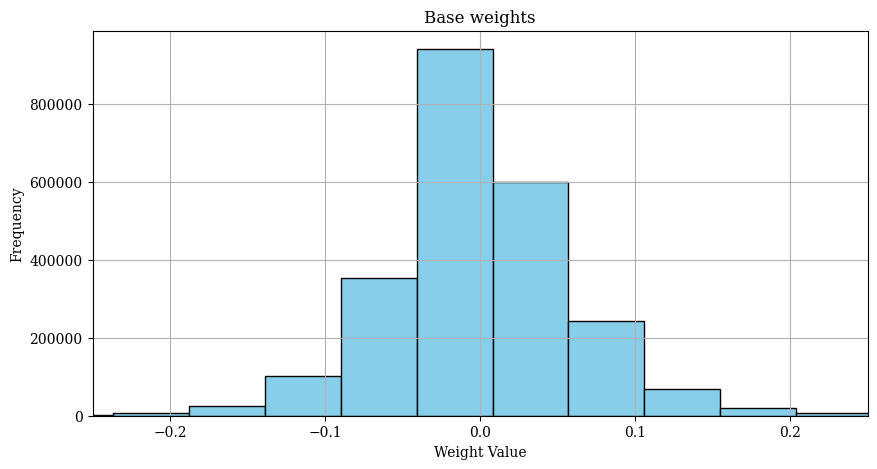

In [29]:
import matplotlib.pyplot as plt

def plot_weight_histogram(model_pruned, title="Weight Histogram"):
    all_weights = []

    for name, param in model_pruned.named_parameters():
        if 'weight' in name and param.requires_grad:
            all_weights.extend(param.detach().cpu().numpy().flatten())

    plt.figure(figsize=(10, 5))
    plt.hist(all_weights, bins=100, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.xlim((-0.25, 0.25))
    plt.show()

plot_weight_histogram(model_pruned, title="Base weights")

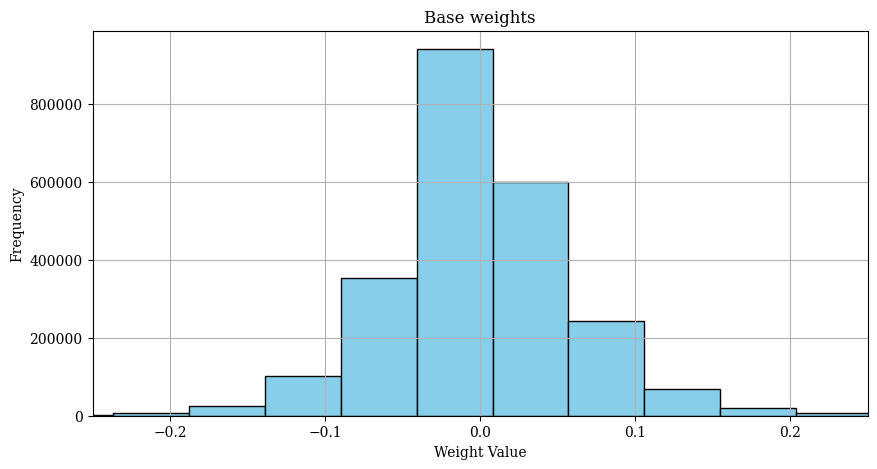

In [41]:
model_pruned = torch.load(r'/Users/SeleemB/Desktop/ENDG511_Final_Project/models/model_language_mobilenet_20_epoch_new_normalize_pruned_iterative_10%_2epoch_5iter.pth')
plot_weight_histogram(model_pruned, title="Base weights")

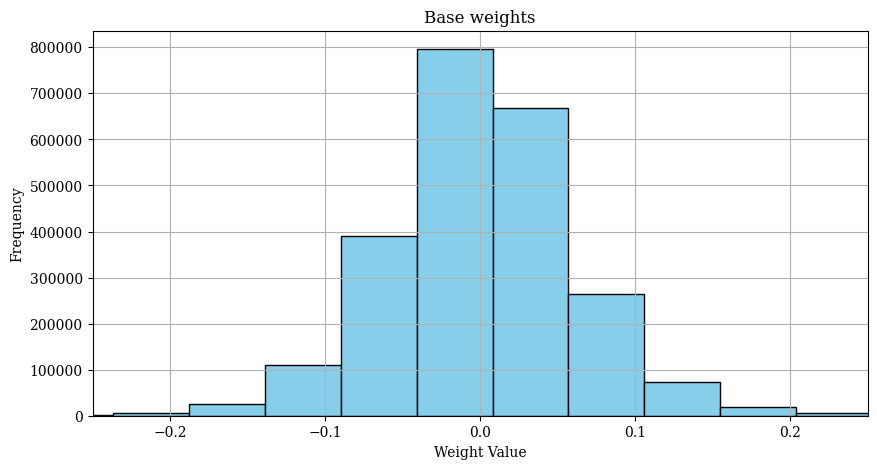

In [ ]:
model_og = torch.load(r'/Users/SeleemB/Desktop/ENDG511_Final_Project/models/model_language_mobilenet_20_epoch_new_normalize_good_dropout.pth')
plot_weight_histogram(model_og, title="Base weights")

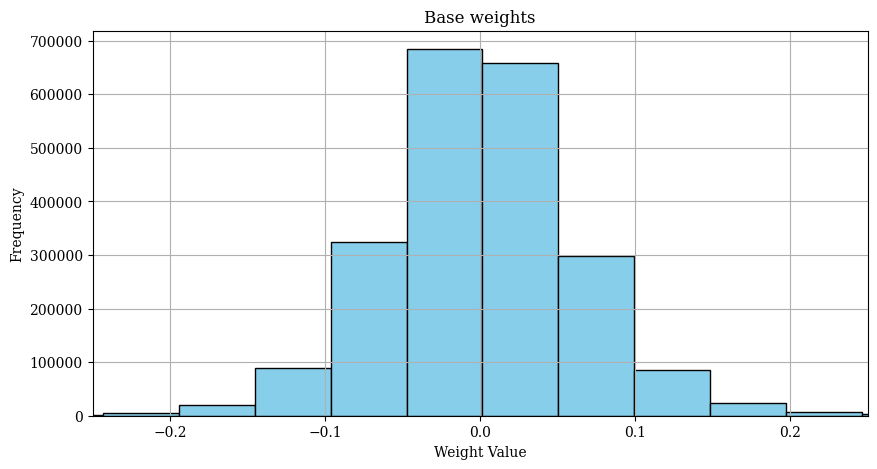

In [40]:
model_pruned_quant = torch.load(r'/Users/SeleemB/Desktop/ENDG511_Final_Project/models/quantized_iterative_pruned_model.pth')
plot_weight_histogram(model_pruned_quant, title="Base weights")

In [32]:
## QUANTIZATION

# quantization (dynamic)

import torch
import torch.nn as nn
import torch.quantization
import os

# Load the pruned model (ensure it's on CPU for quantization)
#model_pruned = torch.load(r'/Users/SeleemB/Desktop/ENDG511_Final_Project/models/quantized_iterative_pruned_model.pth')
model_pruned.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [33]:

# Apply dynamic quantization to Linear layers
quantized_model = torch.quantization.quantize_dynamic(
    model_pruned,                   # the model to quantize
    {nn.Linear},                    # layers to quantize (Conv2d not supported here)
    dtype=torch.qint8               # quantization data type to 8-bit int type
)

# Save the quantized model
quantized_model_path = "models/quantized_iterative_pruned_model_10%_20epoch_5iter.pth"
torch.save(quantized_model, quantized_model_path)

# Report model sizes
original_size = os.path.getsize("/Users/SeleemB/Desktop/ENDG511_Final_Project/models/model_language_mobilenet_20_epoch_new_normalize_good_dropout.pth") / 1e6
quantized_size = os.path.getsize(quantized_model_path) / 1e6

print(f"Original pruned model size: {original_size:.2f} MB")
print(f"Quantized model size: {quantized_size:.2f} MB")


Original pruned model size: 9.85 MB
Quantized model size: 9.35 MB


In [34]:
import random
class LanguageDataset(Dataset):
    """
    A PyTorch Dataset class for loading and processing spectrogram images of radio signals.

    This dataset:
    - Loads images from a specified directory.
    - Applies preprocessing transformations (grayscale conversion, resizing, normalization).
    - Computes class weights for handling class imbalance.
    - Returns image tensors along with their respective labels.

    Attributes:
    ----------
    data_dir : str
        Path to the dataset directory.
    class_labels : list
        List of signal class names.
    class_weights : torch.Tensor
        Normalized inverse frequency weights for each class.
    data_files : list
        List of all image file names in the dataset.
    transform : torchvision.transforms.Compose
        Transformations applied to each image.
    """

    def __init__(self, data_dir, augment=False):
        """
        Initializes the dataset by loading class names, computing class frequencies, and setting up transformations.

        Parameters:
        ----------
        data_dir : str
            Path to the dataset directory.
        """
        self.data_dir = data_dir

        # Define class labels (must match the dataset naming convention)
        self.class_labels = [ 'arabic', 'english', 'german', 'mandarin', 'spanish', 'garbage', 'french']
        #self.class_labels = [ 'arabic', 'german', 'mandarin', 'french']
        self.random_crop = RandomCrop(size=(224, 224))  # assuming final size
        self.augment = augment

        # Get all filenames from the dataset directory
        self.data_files = os.listdir(data_dir)

        # Compute class frequencies (how many samples per class exist)
        class_counts = {label: sum(1 for file in self.data_files if file.startswith(label)) for label in self.class_labels}

        # Compute class weights (inverse frequency) to handle class imbalance
        total_samples = sum(class_counts.values())
        class_weights = [1 / (count / total_samples) if count > 0 else 0 for count in class_counts.values()]

        # Normalize class weights so they sum to 1
        class_weights_sum = sum(class_weights)
        self.class_weights = torch.tensor([w / class_weights_sum for w in class_weights], dtype=torch.float)

        # Define image transformations
        self.transform = Compose([
            ToTensor(),
            Grayscale(num_output_channels=3),
            Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
            RandomPerspective(distortion_scale=0.5, p=0.5),  # Perspective distortion
            Normalize(mean=[-0.9256, -0.8168, -0.5910], std=[0.1704, 0.1742, 0.1734])
        ])

    def __getitem__(self, index):
        """
        Loads an image, applies transformations, and returns it along with its label index.

        Parameters:
        ----------
        index : int
            Index of the sample in the dataset.

        Returns:
        -------
        tuple(torch.Tensor, torch.Tensor)
            Transformed image tensor and its corresponding label index.
        """
        # Get the filename of the sample
        file_name = self.data_files[index]
        file_path = os.path.join(self.data_dir, file_name)

        # Load the image
        image = Image.open(file_path)

        # Rotate 90 degrees (optional, remove if unnecessary)
        image = image.transpose(Image.ROTATE_90)

        # Ensure the image is in RGB mode (some formats might be grayscale)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        image = self.random_crop(image)
        #image = self.transform(image)

       # Convert image to spectrogram (numpy array) and apply augmentation
        spectrogram = np.array(image)

        if self.augment:
            spectrogram = self.apply_spec_augment(spectrogram)

        # Convert to tensor and apply transformations
        image_tensor = self.transform(Image.fromarray(spectrogram))

        if self.augment:
            image_tensor = self.apply_noise(image_tensor)
        # Extract the class label from the filename
        class_label = file_name.split('_')[0]
        sample_number = file_name.split('_')[1]
        label_index = self.class_labels.index(class_label)

        # Apply transformations and return image with label
        return image_tensor, torch.tensor(label_index, dtype=torch.long), sample_number

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
        -------
        int
            Number of files in the dataset.
        """
        return len(self.data_files)
    def apply_spec_augment(self, spectrogram):
        """Apply SpecAugment (time and frequency masking)"""
        # Apply time and frequency masking using librosa
        spectrogram = self.time_mask(spectrogram)
        spectrogram = self.freq_mask(spectrogram)
        return spectrogram

    def time_mask(self, spectrogram, max_mask_size=50):
        """Apply time masking to the spectrogram"""
        n_frames = spectrogram.shape[1]
        mask_start = random.randint(0, n_frames - max_mask_size)
        mask_end = mask_start + random.randint(1, max_mask_size)
        spectrogram[:, mask_start:mask_end] = 0
        return spectrogram

    def freq_mask(self, spectrogram, max_mask_size=10):
        """Apply frequency masking to the spectrogram"""
        n_freqs = spectrogram.shape[0]
        mask_start = random.randint(0, n_freqs - max_mask_size)
        mask_end = mask_start + random.randint(1, max_mask_size)
        spectrogram[mask_start:mask_end, :] = 0
        return spectrogram
    
    def apply_noise(self, img_tensor, noise_level=0.03):
        noise = torch.randn_like(img_tensor) * noise_level
        return torch.clamp(img_tensor + noise, 0.0, 1.0)  # Keep within valid image range

Processing Validation Batches: 100%|██████████| 103/103 [00:16<00:00,  6.19it/s]


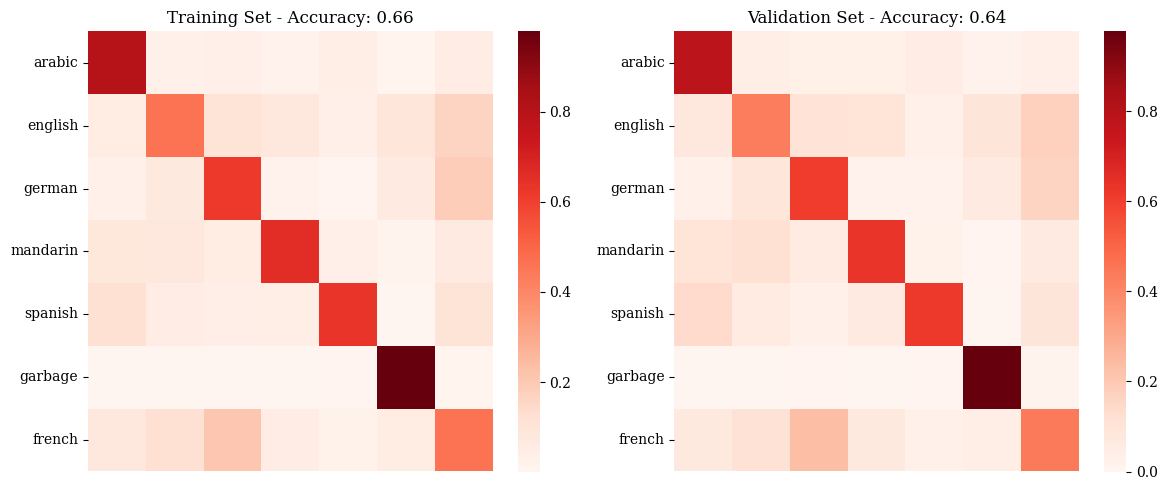

In [36]:
# Define class names for labeling confusion matrices
class_names = dataset.class_labels

# -------------------------
# 📌 Compute Predictions on Training Data
# -------------------------
all_labels_train = []
all_preds_train = []

with torch.no_grad():
    for samples, targets, filename in tqdm(data_loader_train, desc='Processing Training Batches'):
        samples, targets, filename = samples.to(device), targets.to(device), filename
        output = model(samples)  # Forward pass
        all_preds_train.extend(output.argmax(dim=-1).cpu().numpy())  # Get predicted class
        all_labels_train.extend(targets.cpu().numpy())  # Store true labels

# -------------------------
# 📌 Compute Predictions on Validation Data
# -------------------------
all_labels_val = []
all_preds_val = []

with torch.no_grad():
    for samples, targets, filename in tqdm(data_loader_val, desc='Processing Validation Batches'):
        samples, targets, filename = samples.to(device), targets.to(device), filename
        output = model(samples)  # Forward pass
        all_preds_val.extend(output.argmax(dim=-1).cpu().numpy())  # Get predicted class
        all_labels_val.extend(targets.cpu().numpy())  # Store true labels

#all_labels_test = []
#all_preds_test = []
#
#with torch.no_grad():
#    for samples, targets, filename in tqdm(data_loader_test, desc='Processing Test Batches'):
#        samples, targets, filename = samples.to(device), targets.to(device), filename
#        output = model(samples)  # Forward pass
#        all_preds_test.extend(output.argmax(dim=-1).cpu().numpy())  # Get predicted class
#        all_labels_test.extend(targets.cpu().numpy())  # Store true labels

# -------------------------
# 📌 Compute Confusion Matrices
# -------------------------
conf_mat_train = confusion_matrix(all_labels_train, all_preds_train)
conf_mat_val = confusion_matrix(all_labels_val, all_preds_val)
#conf_mat_test = confusion_matrix(all_labels_test, all_preds_test)

# Compute accuracy
accuracy_train = np.trace(conf_mat_train) / np.sum(conf_mat_train)  # Correct predictions / total
accuracy_val = np.trace(conf_mat_val) / np.sum(conf_mat_val)
#accuracy_test = np.trace(conf_mat_test) / np.sum(conf_mat_test)

# Convert to float for normalization
conf_mat_train = conf_mat_train.astype(np.float32)
conf_mat_val = conf_mat_val.astype(np.float32)
#conf_mat_test = conf_mat_test.astype(np.float32)

# Normalize confusion matrices by row (i.e., per-class normalization)
for i in range(len(class_names)):
    conf_mat_train[i] /= np.sum(conf_mat_train[i])  # Normalize training confusion matrix
    conf_mat_val[i] /= np.sum(conf_mat_val[i])  # Normalize val confusion matrix
 #   conf_mat_test[i] /= np.sum(conf_mat_test[i])  # Normalize val confusion matrix

# -------------------------
# 📌 Plot Confusion Matrices
# -------------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create side-by-side subplots

# Plot Training Confusion Matrix
sns.heatmap(conf_mat_train, cmap='Reds', yticklabels=class_names, ax=axs[0])
axs[0].set_title(f'Training Set - Accuracy: {accuracy_train:.2f}')
axs[0].tick_params(axis='y', labelsize=10)
axs[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Plot Test Confusion Matrix
sns.heatmap(conf_mat_val, cmap='Reds', yticklabels=class_names, ax=axs[1])
axs[1].set_title(f'Validation Set - Accuracy: {accuracy_val:.2f}')
axs[1].tick_params(axis='y', labelsize=10)
axs[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

#sns.heatmap(conf_mat_test, cmap='Reds', yticklabels=class_names, ax=axs[2])
#axs[2].set_title(f'Validation Set - Accuracy: {accuracy_test:.2f}')
#axs[2].tick_params(axis='y', labelsize=10)
#axs[2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Adjust layout for better readability
plt.tight_layout()
plt.savefig(Path('conf_radio_signal.png'), dpi=400)  # Save figure
plt.show()

Processing Validation Batches: 100%|██████████| 103/103 [00:13<00:00,  7.46it/s]


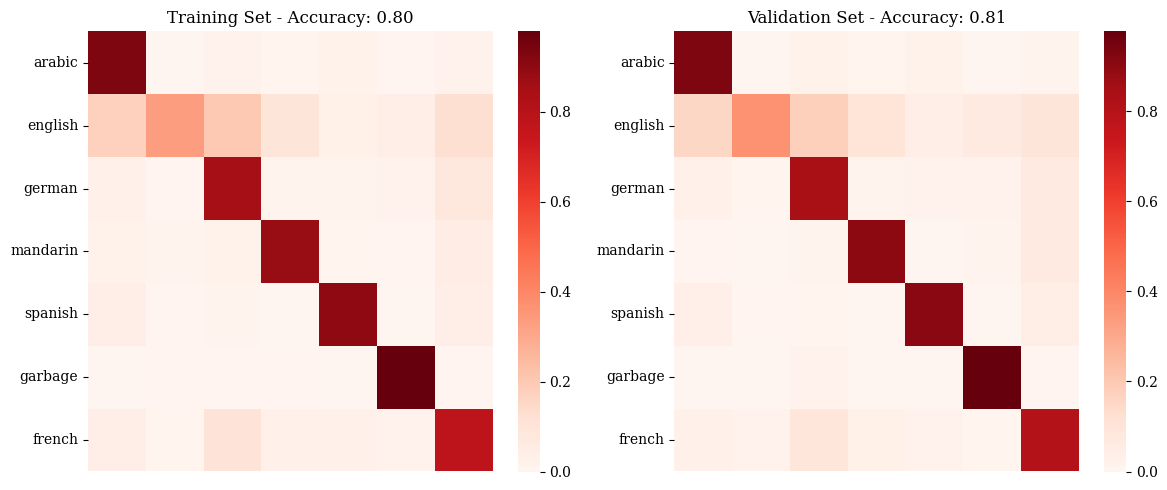

In [ ]:
## Confusion Matrices for Pruned Model (final pruned only)

# Define class names for labeling confusion matrices
class_names = dataset.class_labels

model = torch.load(r'/Users/SeleemB/Desktop/ENDG511_Final_Project/models/model_language_mobilenet_20_epoch_new_normalize_pruned_iterative_10%_2epoch_5iter.pth')

# -------------------------
# 📌 Compute Predictions on Training Data
# -------------------------
all_labels_train = []
all_preds_train = []

with torch.no_grad():
    for samples, targets, filename in tqdm(data_loader_train, desc='Processing Training Batches'):
        samples, targets, filename = samples.to(device), targets.to(device), filename
        output = model(samples)  # Forward pass
        all_preds_train.extend(output.argmax(dim=-1).cpu().numpy())  # Get predicted class
        all_labels_train.extend(targets.cpu().numpy())  # Store true labels

# -------------------------
# 📌 Compute Predictions on Validation Data
# -------------------------
all_labels_val = []
all_preds_val = []

with torch.no_grad():
    for samples, targets, filename in tqdm(data_loader_val, desc='Processing Validation Batches'):
        samples, targets, filename = samples.to(device), targets.to(device), filename
        output = model(samples)  # Forward pass
        all_preds_val.extend(output.argmax(dim=-1).cpu().numpy())  # Get predicted class
        all_labels_val.extend(targets.cpu().numpy())  # Store true labels

#all_labels_test = []
#all_preds_test = []
#
#with torch.no_grad():
#    for samples, targets, filename in tqdm(data_loader_test, desc='Processing Test Batches'):
#        samples, targets, filename = samples.to(device), targets.to(device), filename
#        output = model(samples)  # Forward pass
#        all_preds_test.extend(output.argmax(dim=-1).cpu().numpy())  # Get predicted class
#        all_labels_test.extend(targets.cpu().numpy())  # Store true labels

# -------------------------
# 📌 Compute Confusion Matrices
# -------------------------
conf_mat_train = confusion_matrix(all_labels_train, all_preds_train)
conf_mat_val = confusion_matrix(all_labels_val, all_preds_val)
#conf_mat_test = confusion_matrix(all_labels_test, all_preds_test)

# Compute accuracy
accuracy_train = np.trace(conf_mat_train) / np.sum(conf_mat_train)  # Correct predictions / total
accuracy_val = np.trace(conf_mat_val) / np.sum(conf_mat_val)
#accuracy_test = np.trace(conf_mat_test) / np.sum(conf_mat_test)

# Convert to float for normalization
conf_mat_train = conf_mat_train.astype(np.float32)
conf_mat_val = conf_mat_val.astype(np.float32)
#conf_mat_test = conf_mat_test.astype(np.float32)

# Normalize confusion matrices by row (i.e., per-class normalization)
for i in range(len(class_names)):
    conf_mat_train[i] /= np.sum(conf_mat_train[i])  # Normalize training confusion matrix
    conf_mat_val[i] /= np.sum(conf_mat_val[i])  # Normalize val confusion matrix
 #   conf_mat_test[i] /= np.sum(conf_mat_test[i])  # Normalize val confusion matrix

# -------------------------
# 📌 Plot Confusion Matrices
# -------------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create side-by-side subplots

# Plot Training Confusion Matrix
sns.heatmap(conf_mat_train, cmap='Reds', yticklabels=class_names, ax=axs[0])
axs[0].set_title(f'Training Set - Accuracy: {accuracy_train:.2f}')
axs[0].tick_params(axis='y', labelsize=10)
axs[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Plot Test Confusion Matrix
sns.heatmap(conf_mat_val, cmap='Reds', yticklabels=class_names, ax=axs[1])
axs[1].set_title(f'Validation Set - Accuracy: {accuracy_val:.2f}')
axs[1].tick_params(axis='y', labelsize=10)
axs[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

#sns.heatmap(conf_mat_test, cmap='Reds', yticklabels=class_names, ax=axs[2])
#axs[2].set_title(f'Validation Set - Accuracy: {accuracy_test:.2f}')
#axs[2].tick_params(axis='y', labelsize=10)
#axs[2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Adjust layout for better readability
plt.tight_layout()
plt.savefig(Path('conf_radio_signal.png'), dpi=400)  # Save figure
plt.show()

Processing Validation Batches: 100%|██████████| 103/103 [00:14<00:00,  7.09it/s]


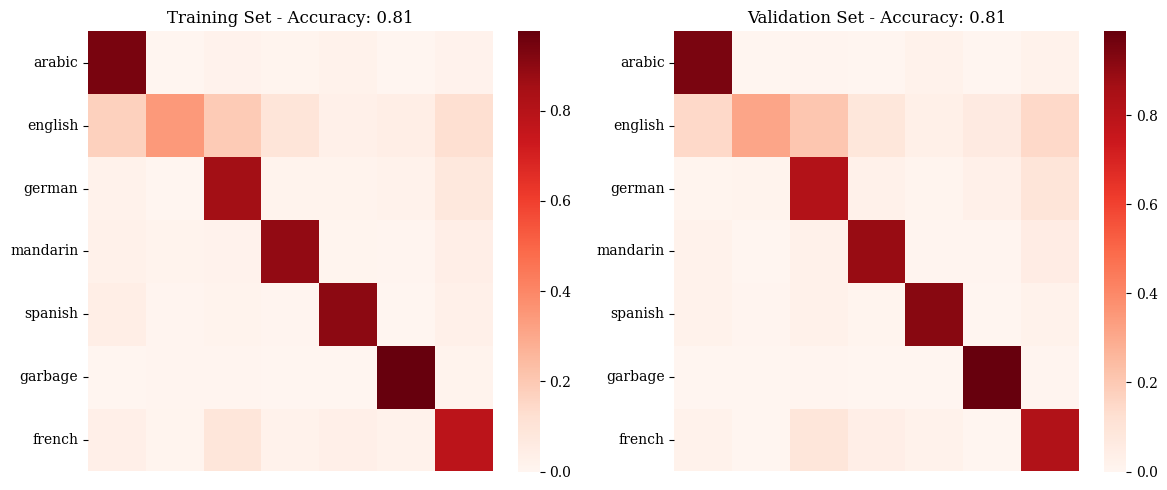

In [ ]:
## Confusion Matrices for Quantized + Pruned Model

# Define class names for labeling confusion matrices
class_names = dataset.class_labels

model = torch.load(r'/Users/SeleemB/Desktop/ENDG511_Final_Project/models/quantized_iterative_pruned_model_2epoch_5iter.pth')

# -------------------------
# 📌 Compute Predictions on Training Data
# -------------------------
all_labels_train = []
all_preds_train = []

with torch.no_grad():
    for samples, targets, filename in tqdm(data_loader_train, desc='Processing Training Batches'):
        samples, targets, filename = samples.to(device), targets.to(device), filename
        output = model(samples)  # Forward pass
        all_preds_train.extend(output.argmax(dim=-1).cpu().numpy())  # Get predicted class
        all_labels_train.extend(targets.cpu().numpy())  # Store true labels

# -------------------------
# 📌 Compute Predictions on Validation Data
# -------------------------
all_labels_val = []
all_preds_val = []

with torch.no_grad():
    for samples, targets, filename in tqdm(data_loader_val, desc='Processing Validation Batches'):
        samples, targets, filename = samples.to(device), targets.to(device), filename
        output = model(samples)  # Forward pass
        all_preds_val.extend(output.argmax(dim=-1).cpu().numpy())  # Get predicted class
        all_labels_val.extend(targets.cpu().numpy())  # Store true labels

#all_labels_test = []
#all_preds_test = []
#
#with torch.no_grad():
#    for samples, targets, filename in tqdm(data_loader_test, desc='Processing Test Batches'):
#        samples, targets, filename = samples.to(device), targets.to(device), filename
#        output = model(samples)  # Forward pass
#        all_preds_test.extend(output.argmax(dim=-1).cpu().numpy())  # Get predicted class
#        all_labels_test.extend(targets.cpu().numpy())  # Store true labels

# -------------------------
# 📌 Compute Confusion Matrices
# -------------------------
conf_mat_train = confusion_matrix(all_labels_train, all_preds_train)
conf_mat_val = confusion_matrix(all_labels_val, all_preds_val)
#conf_mat_test = confusion_matrix(all_labels_test, all_preds_test)

# Compute accuracy
accuracy_train = np.trace(conf_mat_train) / np.sum(conf_mat_train)  # Correct predictions / total
accuracy_val = np.trace(conf_mat_val) / np.sum(conf_mat_val)
#accuracy_test = np.trace(conf_mat_test) / np.sum(conf_mat_test)

# Convert to float for normalization
conf_mat_train = conf_mat_train.astype(np.float32)
conf_mat_val = conf_mat_val.astype(np.float32)
#conf_mat_test = conf_mat_test.astype(np.float32)

# Normalize confusion matrices by row (i.e., per-class normalization)
for i in range(len(class_names)):
    conf_mat_train[i] /= np.sum(conf_mat_train[i])  # Normalize training confusion matrix
    conf_mat_val[i] /= np.sum(conf_mat_val[i])  # Normalize val confusion matrix
 #   conf_mat_test[i] /= np.sum(conf_mat_test[i])  # Normalize val confusion matrix

# -------------------------
# 📌 Plot Confusion Matrices
# -------------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create side-by-side subplots

# Plot Training Confusion Matrix
sns.heatmap(conf_mat_train, cmap='Reds', yticklabels=class_names, ax=axs[0])
axs[0].set_title(f'Training Set - Accuracy: {accuracy_train:.2f}')
axs[0].tick_params(axis='y', labelsize=10)
axs[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Plot Test Confusion Matrix
sns.heatmap(conf_mat_val, cmap='Reds', yticklabels=class_names, ax=axs[1])
axs[1].set_title(f'Validation Set - Accuracy: {accuracy_val:.2f}')
axs[1].tick_params(axis='y', labelsize=10)
axs[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

#sns.heatmap(conf_mat_test, cmap='Reds', yticklabels=class_names, ax=axs[2])
#axs[2].set_title(f'Validation Set - Accuracy: {accuracy_test:.2f}')
#axs[2].tick_params(axis='y', labelsize=10)
#axs[2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Adjust layout for better readability
plt.tight_layout()
plt.savefig(Path('conf_radio_signal.png'), dpi=400)  # Save figure
plt.show()

Processing Validation Batches: 100%|██████████| 103/103 [00:14<00:00,  7.28it/s]


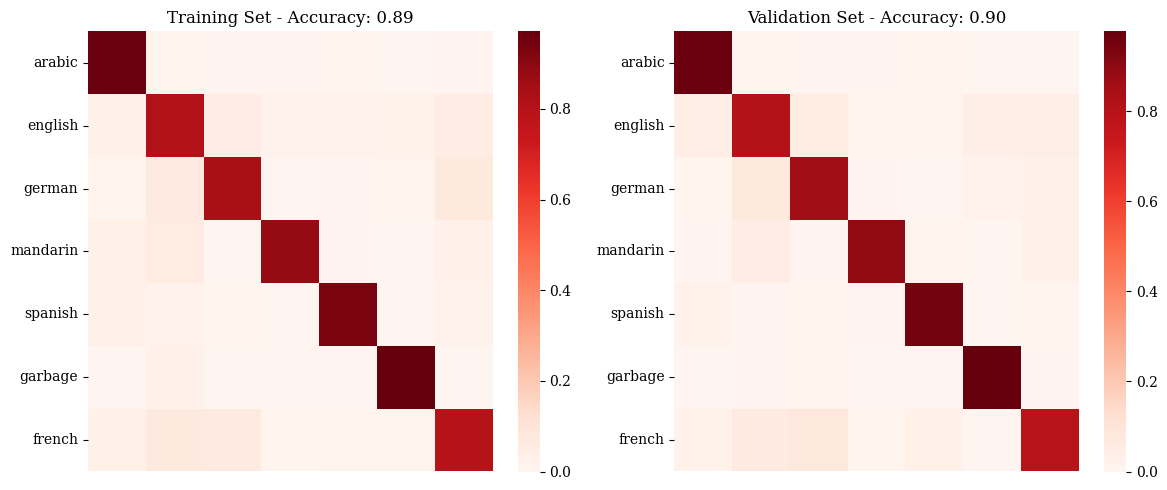

In [39]:
## Confusion Matrices for original model (no prune or quant) with good dropout rate

# Define class names for labeling confusion matrices
class_names = dataset.class_labels

model = torch.load(r'/Users/SeleemB/Desktop/ENDG511_Final_Project/models/model_language_mobilenet_20_epoch_new_normalize_good_dropout.pth')

# -------------------------
# 📌 Compute Predictions on Training Data
# -------------------------
all_labels_train = []
all_preds_train = []

with torch.no_grad():
    for samples, targets, filename in tqdm(data_loader_train, desc='Processing Training Batches'):
        samples, targets, filename = samples.to(device), targets.to(device), filename
        output = model(samples)  # Forward pass
        all_preds_train.extend(output.argmax(dim=-1).cpu().numpy())  # Get predicted class
        all_labels_train.extend(targets.cpu().numpy())  # Store true labels

# -------------------------
# 📌 Compute Predictions on Validation Data
# -------------------------
all_labels_val = []
all_preds_val = []

with torch.no_grad():
    for samples, targets, filename in tqdm(data_loader_val, desc='Processing Validation Batches'):
        samples, targets, filename = samples.to(device), targets.to(device), filename
        output = model(samples)  # Forward pass
        all_preds_val.extend(output.argmax(dim=-1).cpu().numpy())  # Get predicted class
        all_labels_val.extend(targets.cpu().numpy())  # Store true labels

#all_labels_test = []
#all_preds_test = []
#
#with torch.no_grad():
#    for samples, targets, filename in tqdm(data_loader_test, desc='Processing Test Batches'):
#        samples, targets, filename = samples.to(device), targets.to(device), filename
#        output = model(samples)  # Forward pass
#        all_preds_test.extend(output.argmax(dim=-1).cpu().numpy())  # Get predicted class
#        all_labels_test.extend(targets.cpu().numpy())  # Store true labels

# -------------------------
# 📌 Compute Confusion Matrices
# -------------------------
conf_mat_train = confusion_matrix(all_labels_train, all_preds_train)
conf_mat_val = confusion_matrix(all_labels_val, all_preds_val)
#conf_mat_test = confusion_matrix(all_labels_test, all_preds_test)

# Compute accuracy
accuracy_train = np.trace(conf_mat_train) / np.sum(conf_mat_train)  # Correct predictions / total
accuracy_val = np.trace(conf_mat_val) / np.sum(conf_mat_val)
#accuracy_test = np.trace(conf_mat_test) / np.sum(conf_mat_test)

# Convert to float for normalization
conf_mat_train = conf_mat_train.astype(np.float32)
conf_mat_val = conf_mat_val.astype(np.float32)
#conf_mat_test = conf_mat_test.astype(np.float32)

# Normalize confusion matrices by row (i.e., per-class normalization)
for i in range(len(class_names)):
    conf_mat_train[i] /= np.sum(conf_mat_train[i])  # Normalize training confusion matrix
    conf_mat_val[i] /= np.sum(conf_mat_val[i])  # Normalize val confusion matrix
 #   conf_mat_test[i] /= np.sum(conf_mat_test[i])  # Normalize val confusion matrix

# -------------------------
# 📌 Plot Confusion Matrices
# -------------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create side-by-side subplots

# Plot Training Confusion Matrix
sns.heatmap(conf_mat_train, cmap='Reds', yticklabels=class_names, ax=axs[0])
axs[0].set_title(f'Training Set - Accuracy: {accuracy_train:.2f}')
axs[0].tick_params(axis='y', labelsize=10)
axs[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Plot Test Confusion Matrix
sns.heatmap(conf_mat_val, cmap='Reds', yticklabels=class_names, ax=axs[1])
axs[1].set_title(f'Validation Set - Accuracy: {accuracy_val:.2f}')
axs[1].tick_params(axis='y', labelsize=10)
axs[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

#sns.heatmap(conf_mat_test, cmap='Reds', yticklabels=class_names, ax=axs[2])
#axs[2].set_title(f'Validation Set - Accuracy: {accuracy_test:.2f}')
#axs[2].tick_params(axis='y', labelsize=10)
#axs[2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Adjust layout for better readability
plt.tight_layout()
plt.savefig(Path('conf_radio_signal.png'), dpi=400)  # Save figure
plt.show()

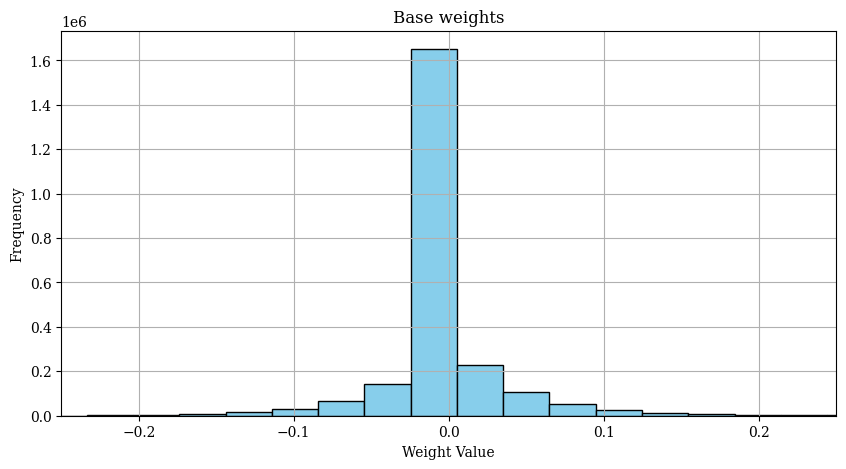

In [ ]:
import matplotlib.pyplot as plt

def plot_weight_histogram(model, title="Weight Histogram"):
    all_weights = []

    for name, param in model.named_parameters():
        if 'weight' in name and param.requires_grad:
            all_weights.extend(param.detach().cpu().numpy().flatten())

    plt.figure(figsize=(10, 5))
    plt.hist(all_weights, bins=100, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.xlim((-0.25, 0.25))
    plt.show()

plot_weight_histogram(model, title="Base weights")

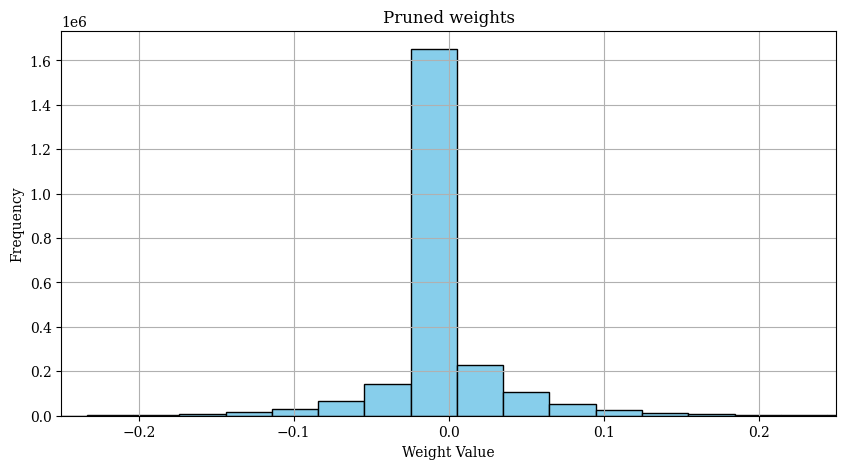

In [ ]:
plot_weight_histogram(model_pruned, title="Pruned weights")

Processing Validation Batches: 100%|██████████| 103/103 [00:03<00:00, 31.93it/s]


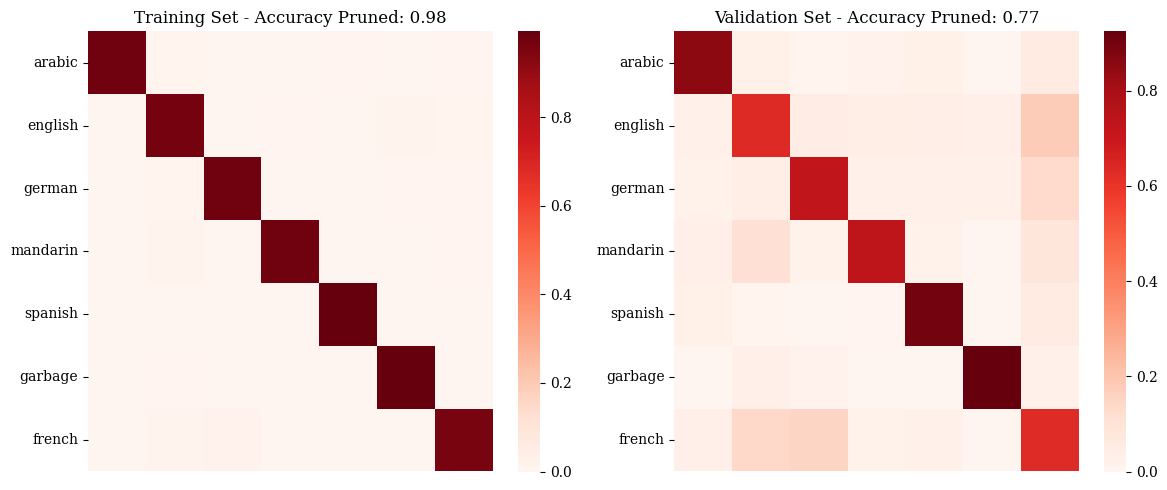

In [ ]:
# Define class names for labeling confusion matrices
class_names = dataset.class_labels

# -------------------------
# 📌 Compute Predictions on Training Data
# -------------------------
all_labels_train_pruned = []
all_preds_train_pruned = []

with torch.no_grad():
    for samples, targets, filename in tqdm(data_loader_train, desc='Processing Training Batches'):
        samples, targets, filename = samples.to(device), targets.to(device), filename
        output = model_pruned(samples)  # Forward pass
        all_preds_train_pruned.extend(output.argmax(dim=-1).cpu().numpy())  # Get predicted class
        all_labels_train_pruned.extend(targets.cpu().numpy())  # Store true labels

# -------------------------
# 📌 Compute Predictions on Validation Data
# -------------------------
all_labels_val_pruned = []
all_preds_val_pruned = []

with torch.no_grad():
    for samples, targets, filename in tqdm(data_loader_val, desc='Processing Validation Batches'):
        samples, targets, filename = samples.to(device), targets.to(device), filename
        output = model_pruned(samples)  # Forward pass
        all_preds_val_pruned.extend(output.argmax(dim=-1).cpu().numpy())  # Get predicted class
        all_labels_val_pruned.extend(targets.cpu().numpy())  # Store true labels

#all_labels_test = []
#all_preds_test = []
#
#with torch.no_grad():
#    for samples, targets, filename in tqdm(data_loader_test, desc='Processing Test Batches'):
#        samples, targets, filename = samples.to(device), targets.to(device), filename
#        output = model(samples)  # Forward pass
#        all_preds_test.extend(output.argmax(dim=-1).cpu().numpy())  # Get predicted class
#        all_labels_test.extend(targets.cpu().numpy())  # Store true labels

# -------------------------
# 📌 Compute Confusion Matrices
# -------------------------
conf_mat_train_pruned = confusion_matrix(all_labels_train_pruned, all_preds_train_pruned)
conf_mat_val_pruned = confusion_matrix(all_labels_val_pruned, all_preds_val_pruned)
#conf_mat_test = confusion_matrix(all_labels_test, all_preds_test)

# Compute accuracy
accuracy_train_pruned = np.trace(conf_mat_train_pruned) / np.sum(conf_mat_train_pruned)  # Correct predictions / total
accuracy_val_pruned = np.trace(conf_mat_val_pruned) / np.sum(conf_mat_val_pruned)
#accuracy_test = np.trace(conf_mat_test) / np.sum(conf_mat_test)

# Convert to float for normalization
conf_mat_train_pruned = conf_mat_train_pruned.astype(np.float32)
conf_mat_val_pruned = conf_mat_val_pruned.astype(np.float32)
#conf_mat_test = conf_mat_test.astype(np.float32)

# Normalize confusion matrices by row (i.e., per-class normalization)
for i in range(len(class_names)):
    conf_mat_train_pruned[i] /= np.sum(conf_mat_train_pruned[i])  # Normalize training confusion matrix
    conf_mat_val_pruned[i] /= np.sum(conf_mat_val_pruned[i])  # Normalize val confusion matrix
 #   conf_mat_test[i] /= np.sum(conf_mat_test[i])  # Normalize val confusion matrix

# -------------------------
# 📌 Plot Confusion Matrices
# -------------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create side-by-side subplots

# Plot Training Confusion Matrix
sns.heatmap(conf_mat_train_pruned, cmap='Reds', yticklabels=class_names, ax=axs[0])
axs[0].set_title(f'Training Set - Accuracy Pruned: {accuracy_train_pruned:.2f}')
axs[0].tick_params(axis='y', labelsize=10)
axs[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Plot Test Confusion Matrix
sns.heatmap(conf_mat_val_pruned, cmap='Reds', yticklabels=class_names, ax=axs[1])
axs[1].set_title(f'Validation Set - Accuracy Pruned: {accuracy_val_pruned:.2f}')
axs[1].tick_params(axis='y', labelsize=10)
axs[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

#sns.heatmap(conf_mat_test, cmap='Reds', yticklabels=class_names, ax=axs[2])
#axs[2].set_title(f'Validation Set - Accuracy: {accuracy_test:.2f}')
#axs[2].tick_params(axis='y', labelsize=10)
#axs[2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Adjust layout for better readability
plt.tight_layout()
plt.savefig(Path('conf_radio_signal_pruned.png'), dpi=400)  # Save figure
plt.show()